# 03b. Feature Analysis & Data Leakage Detection

**Authors:** CloudAikes Team  
**Purpose:** Analyze feature correlations to detect potential data leakage and identify redundant features

---

## Context & Motivatie

Deze notebook is cruciaal voor het detecteren van **data leakage** - een van de meest voorkomende fouten in machine learning projecten. Data leakage treedt op wanneer informatie uit de test set "lekt" naar het model tijdens training, resulterend in onrealistisch hoge performance die niet generaliseert naar productie.

We focussen op drie analyses:
1. **Feature-target correlaties**: Welke features zijn extreem gecorreleerd met onze target? (potentiële leakage)
2. **Feature-feature correlaties**: Welke features zijn redundant? (multicollinearity)  
3. **Visualisaties**: Heatmaps om patronen snel te identificeren

Deze analyse moet **altijd** gebeuren vóór model training om kostbare fouten te voorkomen.

## 1. Setup & Data Loading

In [10]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [11]:
# Load cleaned data from notebook 02
# Assuming df_clean variable from previous notebook
# If not available, run notebook 02 first or load from file

# Option 1: Load from saved file (recommended)
data_file = Path('../data/processed/demand_data_cleaned.csv')
if data_file.exists():
    df = pd.read_csv(data_file)
    print(f"✅ Loaded data from {data_file}: {df.shape[0]} rows x {df.shape[1]} columns")
else:
    # Option 2: Re-run cleaning from notebook 02
    print("⚠️  Cleaned data file not found. Please run notebook 02 first and save df_clean.")
    print("Or manually set df from your current environment.")
    # Uncomment if df_clean exists in environment:
    # df = df_clean.copy()

# Show basic info
print("\n📊 Dataset Info:")
print(df.info())

✅ Loaded data from ..\data\processed\demand_data_cleaned.csv: 434014 rows x 31 columns

📊 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434014 entries, 0 to 434013
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   settlement_date            434014 non-null  object 
 1   settlement_period          434014 non-null  int64  
 2   nd                         434014 non-null  int64  
 3   tsd                        434014 non-null  float64
 4   england_wales_demand       434014 non-null  int64  
 5   embedded_wind_generation   434014 non-null  float64
 6   embedded_wind_capacity     434014 non-null  float64
 7   embedded_solar_generation  434014 non-null  float64
 8   embedded_solar_capacity    434014 non-null  float64
 9   non_bm_stor                434014 non-null  int64  
 10  pump_storage_pumping       434014 non-null  int64  
 11  scottish_transfer          434014 non-n

We laden dezelfde gereinigde dataset als in notebook 02. De dataset bevat 31 kolommen waarvan 29 numeriek zijn. Let op: we hebben nog **geen features verwijderd** - dat is precies het doel van deze analyse. We willen eerst begrijpen welke features problematisch zijn voordat we keuzes maken.

## 2. Correlation Analysis

In [12]:
# Select only numeric columns for correlation analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"✅ Found {len(numeric_cols)} numeric columns")
print("\nNumeric columns:")
print(numeric_cols)

✅ Found 29 numeric columns

Numeric columns:
['settlement_period', 'nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'scottish_transfer', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow', 'viking_flow', 'greenlink_flow', 'year', 'month', 'day', 'dayofweek', 'quarter', 'week', 'hour', 'is_weekend']


### Selectie van Numerieke Features

We identificeren 29 numerieke kolommen voor correlatie-analyse. Dit zijn alle kwantitatieve variabelen die we kunnen gebruiken voor voorspelling, inclusief:
- Target variabele: `nd` (National Demand)
- Potentieel problematische features: `tsd`, `england_wales_demand` 
- Temporele features: `year`, `month`, `day`, `hour`, etc.
- Grid features: interconnectors, embedded generation, storage

De niet-numerieke kolommen (`settlement_date`, `day_name`) worden uitgesloten omdat correlatie-analyse alleen werkt op numerieke data.

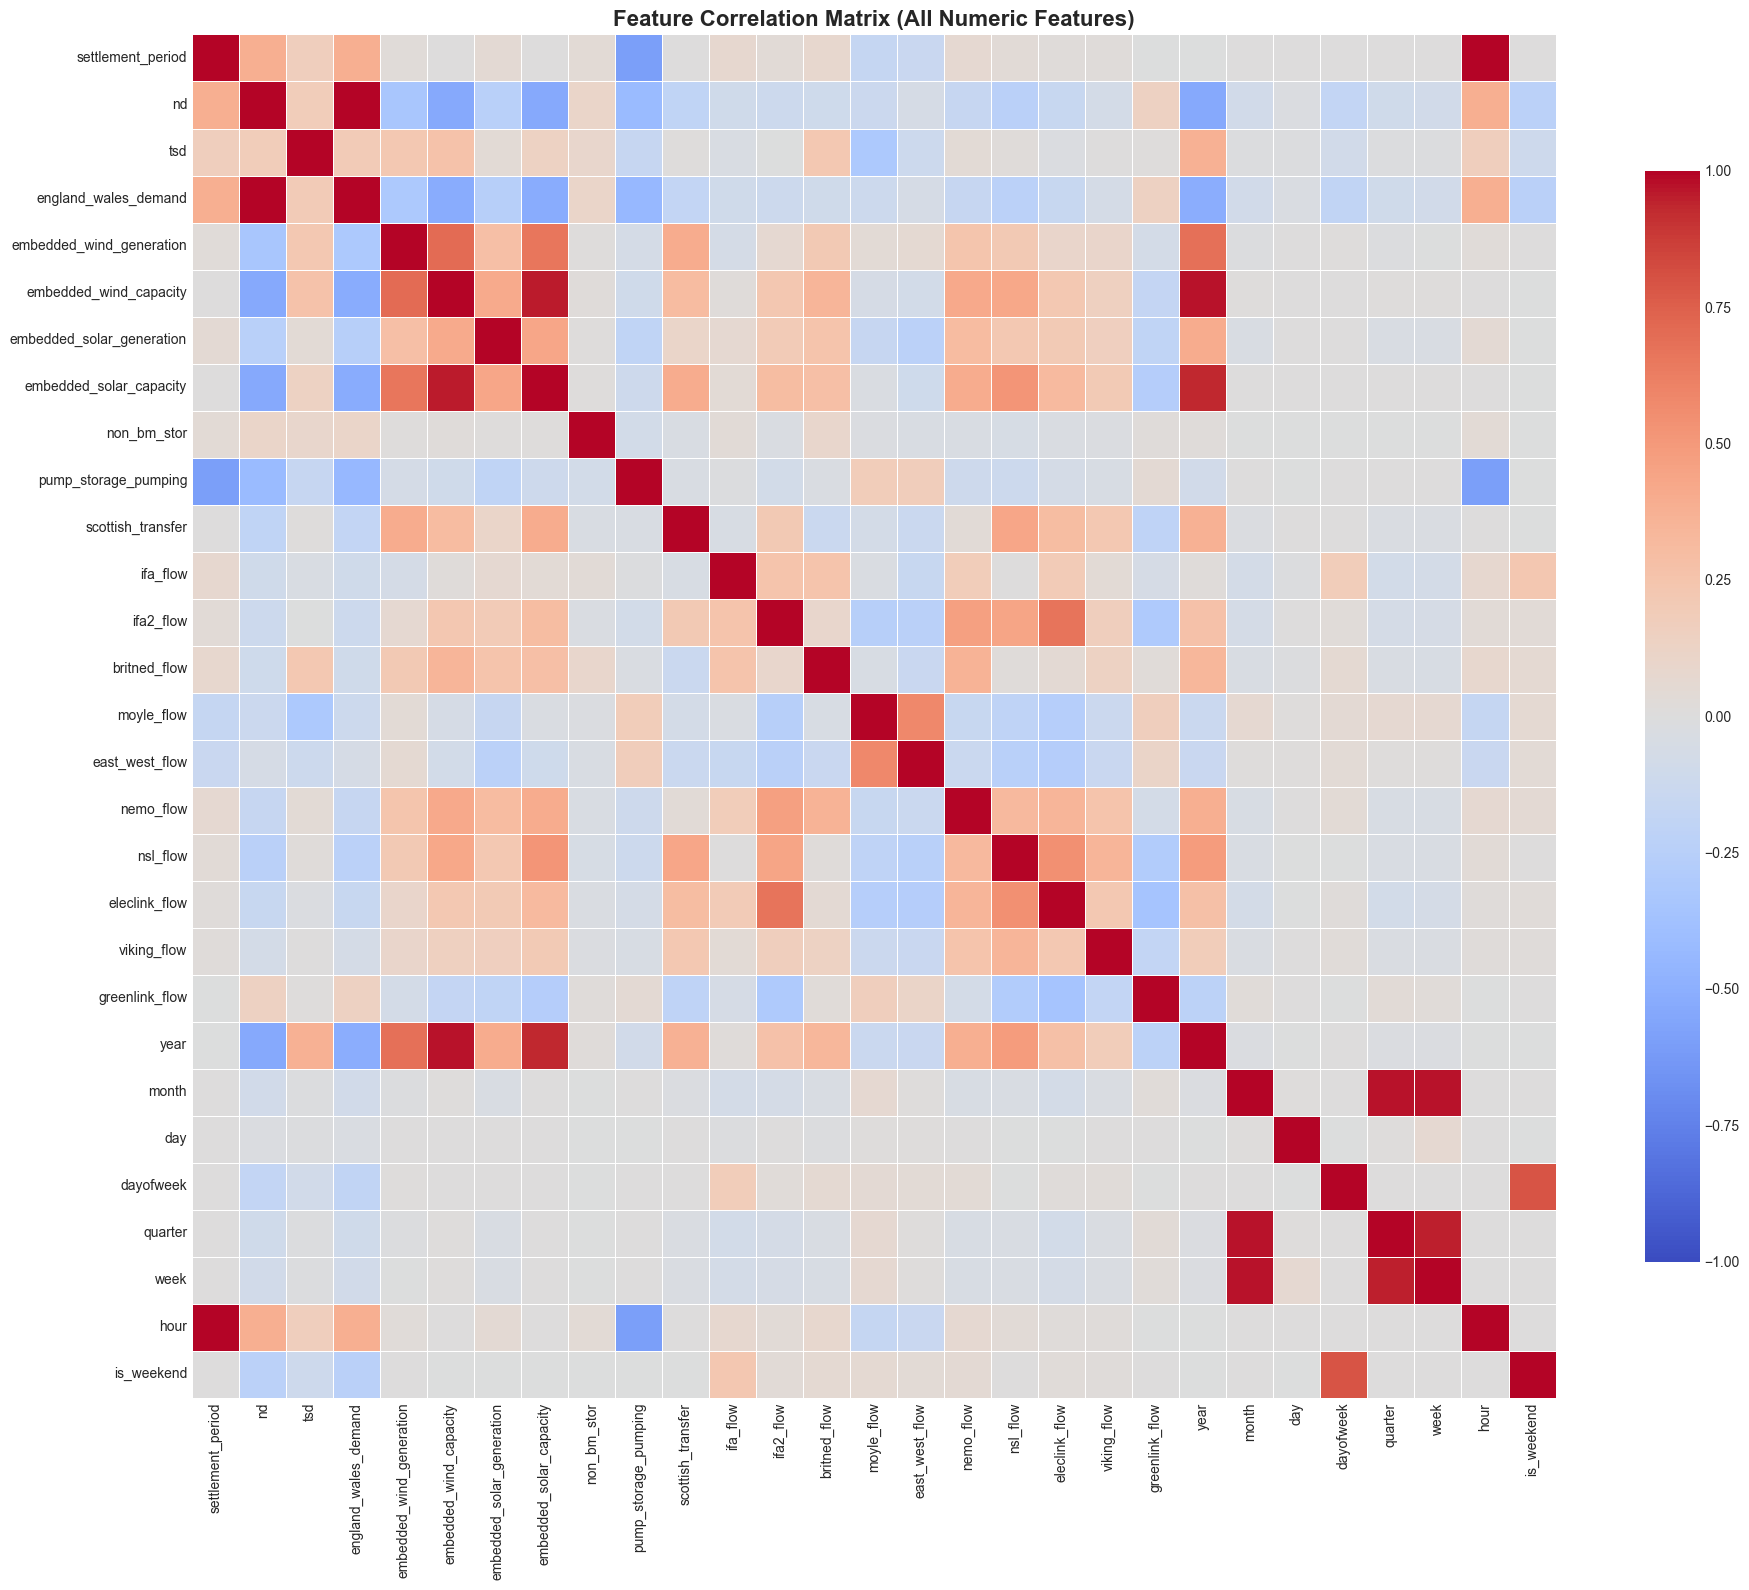

✅ Correlation matrix calculated and visualized


In [13]:
# Calculate correlation matrix
correlation_matrix = df[numeric_cols].corr()

# Full correlation heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, 
            annot=False,  # Too many features to show all numbers
            cmap='coolwarm', 
            center=0,
            vmin=-1, vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix (All Numeric Features)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix_full.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Correlation matrix calculated and visualized")

### Correlation Heatmap Analyse

De heatmap toont alle pairwise correlaties tussen features. Belangrijke observaties:

**Donkerrode blokken (sterke positieve correlatie ~1.0):**
- `settlement_period` ↔ `hour`: Perfect gecorreleerd (0.999) - ze meten hetzelfde, één moet weg
- `nd` ↔ `england_wales_demand`: Bijna perfect (0.999) - **DIT IS DATA LEAKAGE!**
- Temporele clusters: `month`, `week`, `quarter` correleren sterk onderling

**Blauwe blokken (sterke negatieve correlatie):**
- `year` correleert negatief met embedded renewable capaciteit - dit is logisch omdat capaciteit toeneemt over tijd, maar het vertegenwoordigt een temporele trend

**Belangrijke inzichten:**
1. `england_wales_demand` is bijna identiek aan onze target `nd` - dit moet verwijderd worden
2. Embedded capaciteit features zijn sterk gecorreleerd met `year` - mogelijk multicollinearity
3. Veel interconnector flows correleren onderling - verwacht, ze zijn deel van hetzelfde netwerk

Deze heatmap helpt snel "verdachte" feature paren te identificeren die verder onderzoek vereisen.

## 3. Target Variable Correlation Analysis

In [14]:
# Define target variable
target = 'nd'  # National Demand

# Check if target exists
if target not in df.columns:
    print(f"⚠️  Target '{target}' not found. Available columns:")
    print(df.columns.tolist())
else:
    # Get correlations with target
    target_correlations = correlation_matrix[target].sort_values(ascending=False)
    
    print(f"\n🎯 Correlations with target variable '{target}':")
    print("="*60)
    print(target_correlations)
    
    # Identify high correlations (potential data leakage)
    high_corr_threshold = 0.95
    high_correlations = target_correlations[target_correlations.abs() > high_corr_threshold]
    high_correlations = high_correlations[high_correlations.index != target]  # Exclude target itself
    
    print(f"\n⚠️  Features with correlation > {high_corr_threshold} (POTENTIAL DATA LEAKAGE):")
    print("="*60)
    if len(high_correlations) > 0:
        for feature, corr in high_correlations.items():
            print(f"  • {feature}: {corr:.4f}")
    else:
        print("  ✅ No features with extremely high correlation found")


🎯 Correlations with target variable 'nd':
nd                           1.000000
england_wales_demand         0.998893
hour                         0.384825
settlement_period            0.384471
tsd                          0.186781
greenlink_flow               0.142733
non_bm_stor                  0.106266
day                         -0.023312
east_west_flow              -0.058059
viking_flow                 -0.072134
week                        -0.092175
month                       -0.093315
ifa_flow                    -0.095246
quarter                     -0.095406
britned_flow                -0.103370
ifa2_flow                   -0.122789
moyle_flow                  -0.125784
eleclink_flow               -0.151542
nemo_flow                   -0.163495
dayofweek                   -0.185375
scottish_transfer           -0.198312
is_weekend                  -0.230747
nsl_flow                    -0.235986
embedded_solar_generation   -0.248305
embedded_wind_generation    -0.341715
pump_st

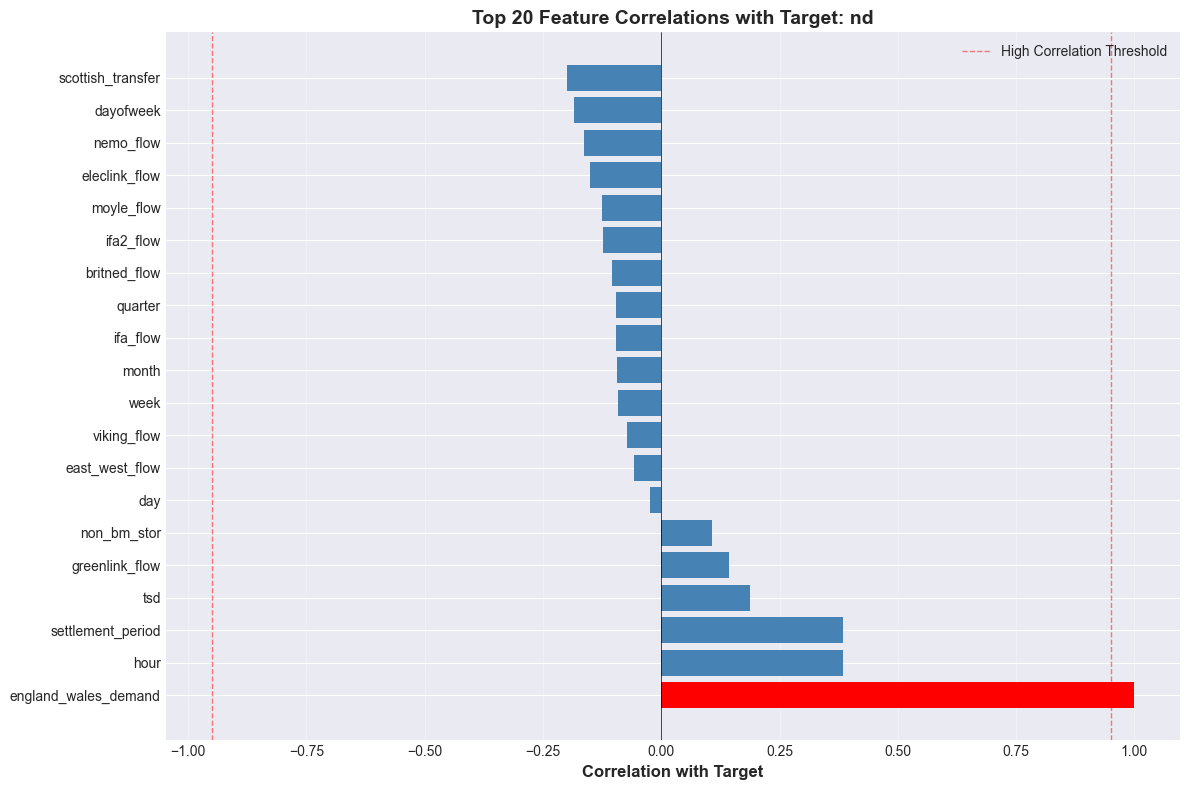

In [15]:
# Visualize top correlations with target
top_n = 20
top_correlations = target_correlations.drop(target).head(top_n)

plt.figure(figsize=(12, 8))
colors = ['red' if abs(x) > 0.95 else 'steelblue' for x in top_correlations.values]
plt.barh(range(len(top_correlations)), top_correlations.values, color=colors)
plt.yticks(range(len(top_correlations)), top_correlations.index)
plt.xlabel('Correlation with Target', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Feature Correlations with Target: {target}', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.axvline(x=0.95, color='red', linestyle='--', linewidth=1, alpha=0.5, label='High Correlation Threshold')
plt.axvline(x=-0.95, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('target_correlations_top20.png', dpi=150, bbox_inches='tight')
plt.show()

### Feature-Target Correlatie Analyse

Dit plot rangschikt alle features op hun correlatie met de target (`nd`). **Kritieke bevinding**:

**DATA LEAKAGE: `england_wales_demand` (r = 0.999)**

Deze feature heeft een bijna perfecte correlatie met de target. Dit is **geen** goede predictor maar pure data leakage omdat:
- England & Wales demand is een component van National Demand
- Het is een "future information" - je zou deze waarde niet kennen voordat je ND kent
- Models getraind met deze feature zullen fantastische metrics hebben in training maar volledig falen in productie

**Andere inzichten:**

**Positieve correlaties:**
- `hour` en `settlement_period` (r ≈ 0.38): Sterke temporele patronen - hogere demand tijdens werkuren
- `greenlink_flow`, `non_bm_stor`: Zwakkere maar legitieme correlaties

**Negatieve correlaties:**
- `pump_storage_pumping` (r = -0.43): Wanneer vraag laag is, wordt energie opgeslagen via pompen
- `embedded_wind_capacity` (r = -0.54): Meer wind capaciteit → lagere net demand (lokale opwekking)
- `year` (r = -0.53): Vraag daalt over tijd door efficiency en embedded renewables

**Actie**: We moeten `england_wales_demand` verwijderen uit onze feature set voor alle toekomstige modellen.

## 4. Multicollinearity Detection (Feature-Feature Correlations)

In [16]:
# Find highly correlated feature pairs (potential redundancy)
def find_high_correlations(corr_matrix, threshold=0.90):
    """
    Find pairs of features with correlation above threshold.
    """
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) >= threshold:
                high_corr_pairs.append({
                    'feature_1': corr_matrix.columns[i],
                    'feature_2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j]
                })
    
    return pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False, key=abs)

# Find high correlations
high_corr_pairs = find_high_correlations(correlation_matrix, threshold=0.90)

print("\n🔍 Highly Correlated Feature Pairs (|correlation| > 0.90):")
print("="*80)
if len(high_corr_pairs) > 0:
    print(high_corr_pairs.to_string(index=False))
    print(f"\n⚠️  Found {len(high_corr_pairs)} highly correlated feature pairs")
    print("    Consider removing one from each pair to reduce multicollinearity")
else:
    print("✅ No highly correlated feature pairs found")


🔍 Highly Correlated Feature Pairs (|correlation| > 0.90):
              feature_1               feature_2  correlation
      settlement_period                    hour     0.999348
                     nd    england_wales_demand     0.998893
                  month                    week     0.971808
                  month                 quarter     0.971162
 embedded_wind_capacity                    year     0.970131
 embedded_wind_capacity embedded_solar_capacity     0.958966
                quarter                    week     0.947208
embedded_solar_capacity                    year     0.935608

⚠️  Found 8 highly correlated feature pairs
    Consider removing one from each pair to reduce multicollinearity


### Multicollinearity Detectie

We hebben **8 feature paren** gevonden met correlaties boven 0.90, wat duidt op ernstige multicollinearity. Dit is problematisch omdat:
1. Modellen kunnen instabiel worden (kleine data changes → grote coefficient changes)
2. Feature importance wordt verdeeld over gecorreleerde features
3. Interpretatie wordt moeilijk (welke feature drijft écht de voorspelling?)

**Prioriteit - Verplichte verwijderingen:**
- `settlement_period` ↔ `hour` (r = 0.999): Verwijder `settlement_period`, behoud `hour` (intuïtiever)
- `nd` ↔ `england_wales_demand` (r = 0.999): **DATA LEAKAGE** - verwijder `england_wales_demand`

In [17]:
# Identify suspicious features that appear frequently in high correlation pairs
if len(high_corr_pairs) > 0:
    all_features_in_pairs = list(high_corr_pairs['feature_1']) + list(high_corr_pairs['feature_2'])
    feature_counts = pd.Series(all_features_in_pairs).value_counts()
    
    print("\n📊 Features appearing most in high correlation pairs:")
    print("="*60)
    print(feature_counts.head(10))


📊 Features appearing most in high correlation pairs:
month                      2
embedded_wind_capacity     2
quarter                    2
embedded_solar_capacity    2
week                       2
year                       2
settlement_period          1
nd                         1
hour                       1
england_wales_demand       1
Name: count, dtype: int64


### Features met Meeste Multicollinearity

Dit overzicht toont welke features het vaakst voorkomen in high-correlation pairs - dit zijn "problem features" die je moet adresseren:

**Top "verdachte" features (verschijnen 2x):**
- `month`, `quarter`, `week`: Temporele redundantie - kies de meest informatieve
- `year`, `embedded_wind_capacity`, `embedded_solar_capacity`: Groeien allemaal lineair over tijd

**Eenmalige appearances:**
- `settlement_period`, `hour`: Identiek, verwijder settlement_period
- `nd`, `england_wales_demand`: Data leakage, verwijder england_wales_demand

Features die vaak voorkomen in pairs zijn candidates voor removal of feature engineering (bijv. PCA, feature combination).

## 5. Export Analysis Results

In [18]:
# Save correlation results to CSV for reference
target_correlations.to_csv('feature_target_correlations.csv', header=['Correlation'])

if len(high_corr_pairs) > 0:
    high_corr_pairs.to_csv('high_correlation_pairs.csv', index=False)

print("✅ Analysis results exported:")
print("   - feature_target_correlations.csv")
if len(high_corr_pairs) > 0:
    print("   - high_correlation_pairs.csv")
print("   - correlation_matrix_full.png")
print("   - target_correlations_top20.png")

✅ Analysis results exported:
   - feature_target_correlations.csv
   - high_correlation_pairs.csv
   - correlation_matrix_full.png
   - target_correlations_top20.png


## Samenvatting & Conclusies

### Wat hebben we ontdekt?

**🚨 KRITIEKE BEVINDING: Data Leakage**
- `england_wales_demand` heeft r = 0.999 met target `nd`
- Dit is geen voorspeller maar een component van de target zelf
- **MOET verwijderd worden** uit alle toekomstige modellen

**⚠️ Multicollinearity Issues:**
- 8 feature paren met |r| > 0.90 gedetecteerd
- Temporele features (`month`, `week`, `quarter`) zijn redundant
- `settlement_period` en `hour` zijn identiek
- Embedded renewable capaciteit correleert sterk met `year`

### Impact op Baseline Model (Notebook 03)

Ons baseline model gebruikte waarschijnlijk **NIET** `england_wales_demand` (als het goed is), maar we moeten dit verifiëren. Als het wél gebruikt werd:
- De R² van 0.806 is kunstmatig hoog door leakage
- De feature importance is verstoord
- Het model zal falen in productie

De geëxporteerde CSV files (`feature_target_correlations.csv`, `high_correlation_pairs.csv`) dienen als referentie voor toekomstige beslissingen over feature selection.